<a href="https://colab.research.google.com/github/leinaxd/NOTES/blob/main/digital_image_processing/notebooks/9_unitary_transforms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import urllib.request

In [ ]:
url = "https://github.com/leinaxd/NOTES/raw/main/digital_image_processing/notebooks/bank.jpeg"
with urllib.request.urlopen(url) as url:
    img = plt.imread(url, format='jpg')
plt.imshow(img)
plt.axis('off')

print(img.shape)

In [ ]:
r_mask = img[:, :, 0]
g_mask = img[:, :, 1]
b_mask = img[:, :, 2]

#turn image to gray
g_img = r_mask*0.2989 + g_mask*0.5870 + b_mask*0.1140
u_img = np.uint8(g_img)

# Basis Functions

Sources:

- https://users.cs.cf.ac.uk/dave/Multimedia/node231.html

1. show all basis functions (spatial, fourier, cosine, sine, hadamart, haart)
2. Show the contribution of each basis on the image
3. Get the 90% most energetic components
4. iterate an image, appending one coefficient a time. you should see an increase of resolution.

- Spatial Basis
- Fourier Basis
- Discrete Cosine Basis
- Discrete Sine Basis
- Hadamart Basis
- Haar Basis

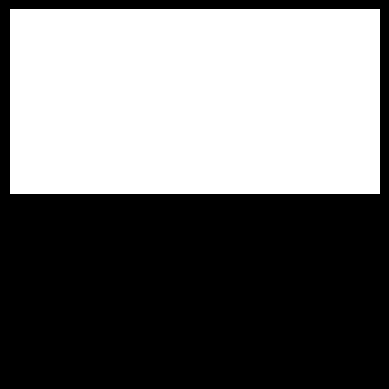

In [612]:
"""
Note. 
    - A is a 1D basis matrix, where each row Au is one vector
    - The 2D Basis B is constructed via Au, Av 1D vectors
    - Au, Av are vectors, while B is a matrix
    - You get the projection coefficient with an image by multplying Au@im@Av.T (dot product)
    - While you get the 2D basis via B = Au@Av (outer product)

"""
def basis_spatial(u, v, NFFT, im=None):
    H = np.eye(NFFT,dtype=float)
    Au = H[[u], :]
    Av = H[[v], :]
    # Au = np.zeros((NFFT, NFFT))
    # Av = np.zeros((NFFT, NFFT))
    # Au[u, :] = 1
    # Av[v, :] = 1
    # fn = Au*Av
    # fn = np.zeros((NFFT, NFFT))
    # fn[m, n] = 1.0
    B = Au.T@Av
    if im is not None: return B, Au@im@Av.T
    else:              return B

def basis_fourier(u,v, NFFT, im=None):
    X = np.arange(NFFT)
    Y = np.arange(NFFT)
    x, y = np.meshgrid(X, Y)
    A = np.exp(-2j*np.pi * x*y/NFFT)
    Au = A[[u], :]
    Av = A[[v], :]
    # Au = np.exp(-2j*np.pi * u/NFFT*x)
    # Av = np.exp(-2j*np.pi * v/NFFT*y)
    # fn = Au*Av
    # fn = np.real(fn)
    # return fn
    B = Au.T@Av
    B = np.real(B)
    if im is not None: return B, Au@im@Av.T
    else:              return B
    
def basis_cosine(u, v, NFFT, im=None):
    # Au = np.zeros((NFFT, NFFT))
    # Av = np.zeros((NFFT, NFFT))
    # Au[0, :] = 1/np.sqrt(NFFT)
    # Av[0, :] = 1/np.sqrt(NFFT)
    # for n in range(NFFT):
    #     Au[n,:] = np.sqrt(2/NFFT) * np.cos(np.pi/NFFT*u*(n+1/2))
    #     Av[n,:] = np.sqrt(2/NFFT) * np.cos(np.pi/NFFT*v*(n+1/2))
    # Av = Av.T
    # return Au*Av
    A = np.zeros((NFFT, NFFT))
    A[0, :] = 1/np.sqrt(NFFT)
    for k in range(1,NFFT):
        for i in range(NFFT):
            A[k,i] = np.sqrt(2/NFFT) * np.cos(np.pi/NFFT*k*(i+1/2))
    Au = A[[u], :]
    Av = A[[v], :]
    B = Au.T@Av
    if im is not None: return B, Au@im@Av.T
    else:              return B

def basis_sine(u, v, NFFT, im=None):
    # Au = np.zeros((NFFT, NFFT))
    # Av = np.zeros((NFFT, NFFT))
    # for n in range(NFFT):
    #     Au[n,:] = np.sqrt(2/(NFFT+1)) * np.sin(np.pi/(NFFT+1)*(u+1)*(n+1))
    #     Av[n,:] = np.sqrt(2/(NFFT+1)) * np.sin(np.pi/(NFFT+1)*(v+1)*(n+1))
    # Av = Av.T
    # return Au*Av
    A = np.zeros((NFFT, NFFT))
    for k in range(NFFT):
        for i in range(NFFT):
            A[k,i] = np.sqrt(2/(NFFT+1)) * np.sin(np.pi/(NFFT+1)*(i+1)*(k+1))
    Au = A[[u], :]
    Av = A[[v], :]
    B = Au.T@Av
    if im is not None: return B, Au@im@Av.T
    else:              return B
def basis_hadamard(u, v, NFFT,im=None):
    A = np.ones((NFFT, NFFT))
    n=1
    while n < NFFT:
        for i in range(n):
            for j in range(n):
                A[i+n, j] = A[i, j]
                A[i, j+n] = A[i, j]
                A[i+n, j+n] = -A[i, j]
        n*=2
    A = A/(np.sqrt(NFFT))
    Au = A[[u], :]
    Av = A[[v], :]
    B = Au.T@Av
    if im is not None: return B, Au@im@Av.T
    else:              return B
def basis_haar(u, v, NFFT, im=None):
    A = np.zeros((NFFT, NFFT))
    M = np.array([1, -1]) #Mother wavelet
    scale_ix = 0
    shift_ix = 0
    for k in range(NFFT):
        scale = NFFT//(2**scale_ix)
        shift=shift_ix*len(M)
        for j in range(NFFT):
            ix = j//scale-shift
            A[k,j] = M[ix] if 0 <= ix and ix<=1 else 0
        if ix <= len(M): #Have I finished rotating all the coefficients of the mother wave?
            scale_ix += 1
            shift_ix = 0
        else:
            shift_ix += 1
    #Normalize
    for i in range(NFFT):
        A[i, :] /= np.sqrt(np.sum(A[i,:]**2))
    
    Au = A[[u],:]
    Av = A[[v],:]
    B = Au.T@Av
    if im is not None: return B, Au@im@Av.T
    else:              return B

# TEST IMAGES
# im_1 = [[1.,2,3,4,5,6,7,8],[10,20,30,40,50,60,70,80],[100,200,300,400,500,600,700,800],[1E3,2E3,3E3,4E3,5E3,6E3,7E3,8E3],[1E4,2E4,3E4,4E4,5E4,6E4,7E4,8E4],[1E5,2E5,3E5,4E5,5E5,6E5,7E5,8E5],[1E6,2E6,3E6,4E6,5E6,6E6,7E6,8E6],[1E7,2E7,3E7,4E7,5E7,6E7,7E7,8E7]]
# im_2 = [[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,1,1,0,0,0],[0,0,0,1,1,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0],[0,0,0,0,0,0,0,0]]
# im = np.array(im_2)

# Just Plot the basis
# plt.imshow(basis_spatial(0,2, 8), cmap='gray');
# plt.imshow(basis_fourier(1,0, 8), cmap='gray');
# plt.imshow(basis_cosine(1,1, 8), cmap='gray');
# plt.imshow(basis_sine(0,0, 8), cmap='gray');
# plt.imshow(basis_hadamard(0,4,8), cmap='gray')
# plt.imshow(basis_haar(1,0,8), cmap='gray')

# Plot the basis and projection to an image
# B, c = basis_spatial(4, 2, 8, im=im)
# B, c = basis_fourier(2, 2, 8, im=im)
# B, c = basis_cosine(1, 0, 8, im=im)
# B, c = basis_sine(0, 0, 8, im=im)
# print(np.abs(c[0,0]), c)
# plt.imshow(im, cmap='gray')
# plt.imshow(B, cmap='gray')
# Plot off
plt.axis('off');

In [ ]:
plt.style.use('dark_background')
#@markdown Plot each 2D-basis for each transform
spatial = False #@param {'type':'boolean'}
fourier = False #@param {'type':'boolean'}
cosine = False #@param {'type':'boolean'}
sine = False #@param {'type':'boolean'}
hadamard = False #@param {'type':'boolean'}
haar = True #@param {'type':'boolean'}
NFFT=8
# Spatial Basis
if spatial:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_spatial(x, y, NFFT), cmap='bone')
            ax[x,y].set_xticks([])
            ax[x,y].set_yticks([])
    fig.suptitle('Spatial Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Fourier Basis
if fourier:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_fourier(x, y, NFFT), cmap='bone',vmin=-1, vmax=1)
            ax[x,y].axis('off')
    fig.suptitle('Fourier Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Cosine Basis
if cosine:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_cosine(x, y, NFFT), cmap='bone')
            ax[x,y].axis('off')
    fig.suptitle('Cosine Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Cosine Basis
if sine:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_sine(x, y, NFFT), cmap='bone')
            ax[x,y].axis('off')
    fig.suptitle('Sine Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
if hadamard:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_hadamard(x, y, NFFT), cmap='bone')
            ax[x,y].axis('off')
    fig.suptitle('Hadamart Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
if haar:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    for x in range(NFFT):
        for y in range(NFFT):
            ax[x,y].imshow(basis_haar(x, y, NFFT), cmap='bone')
            ax[x,y].axis('off')
    fig.suptitle('Haar Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)');

Image projected into the basis

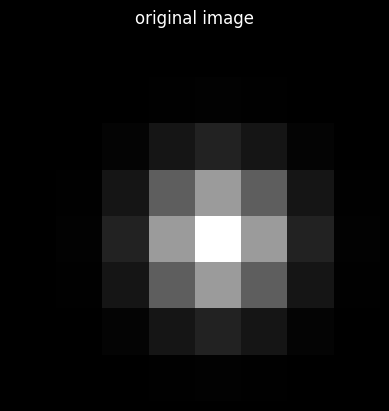

In [654]:
from scipy import ndimage
plt.style.use('dark_background')

NFFT = 8
perc = 0.9 #which coeficients have 90% energy
im = np.zeros((8,8))
im[4,4]=1
im = ndimage.gaussian_filter(im, sigma=1)

plt.imshow(im, cmap='gray')
plt.title('original image')
plt.axis('off');

<ipython-input-653-4ab7cb20422f>:36: ComplexWarning: Casting complex values to real discards the imaginary part
  COEF[x,y]=C[0,0]


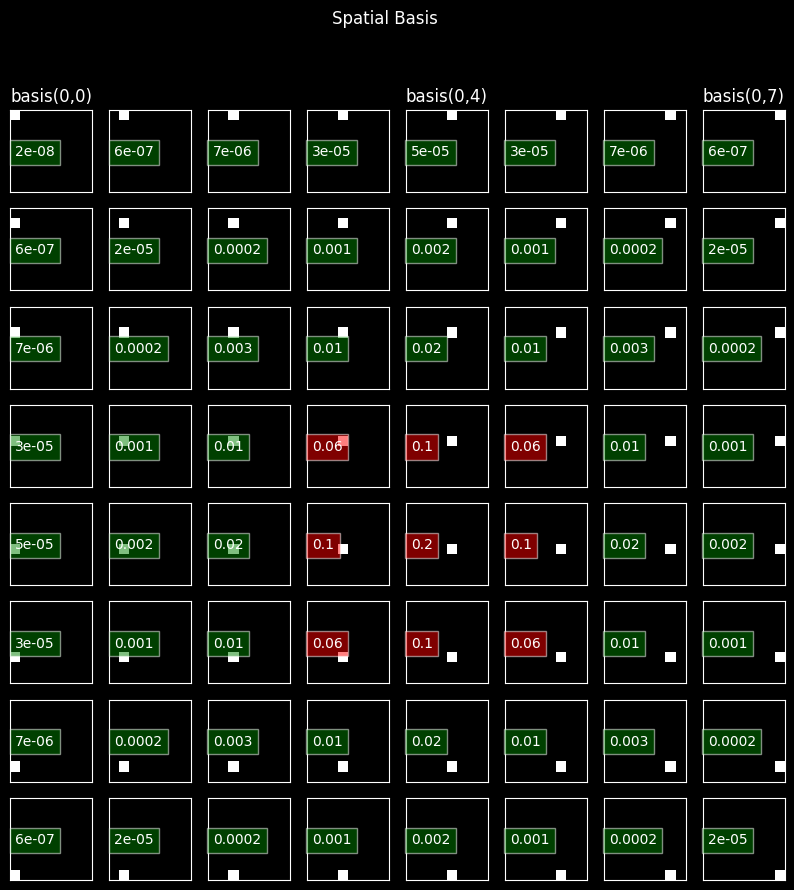

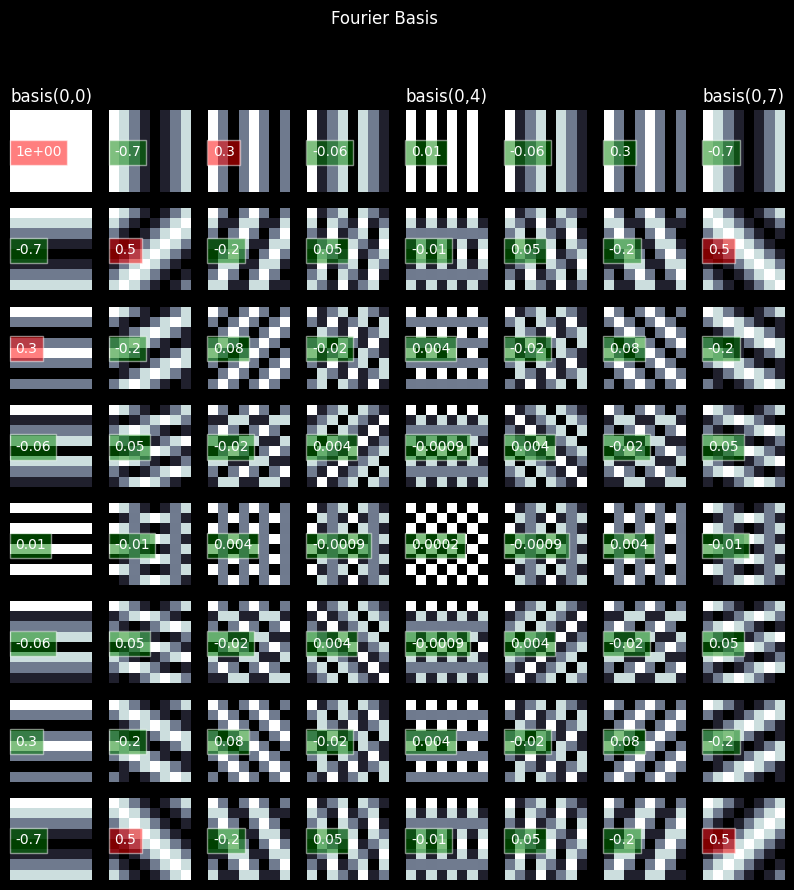

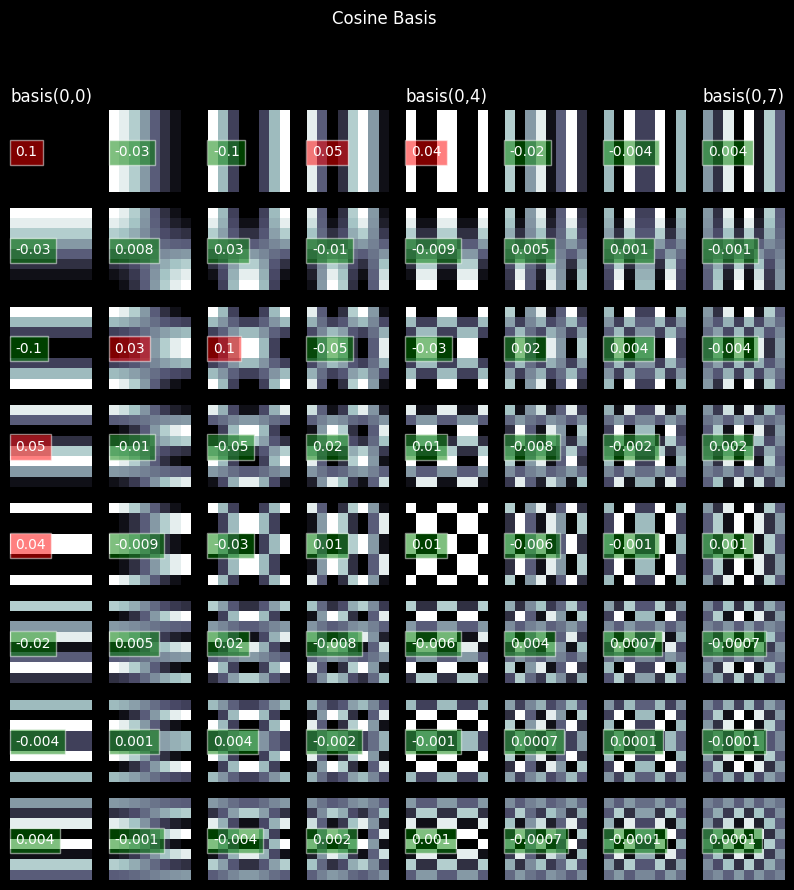

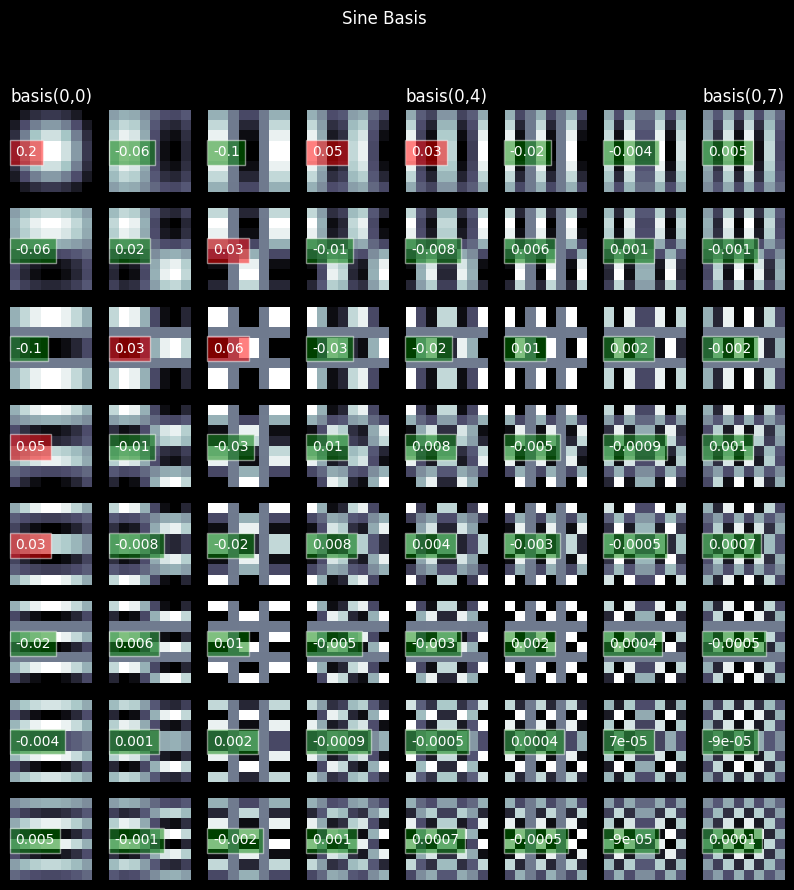

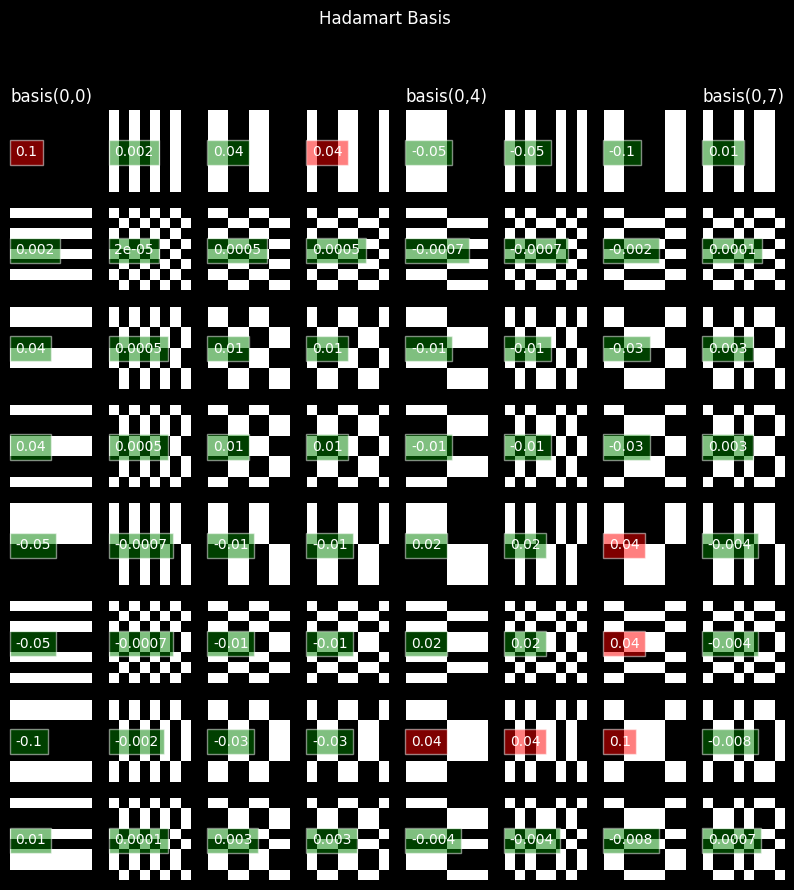

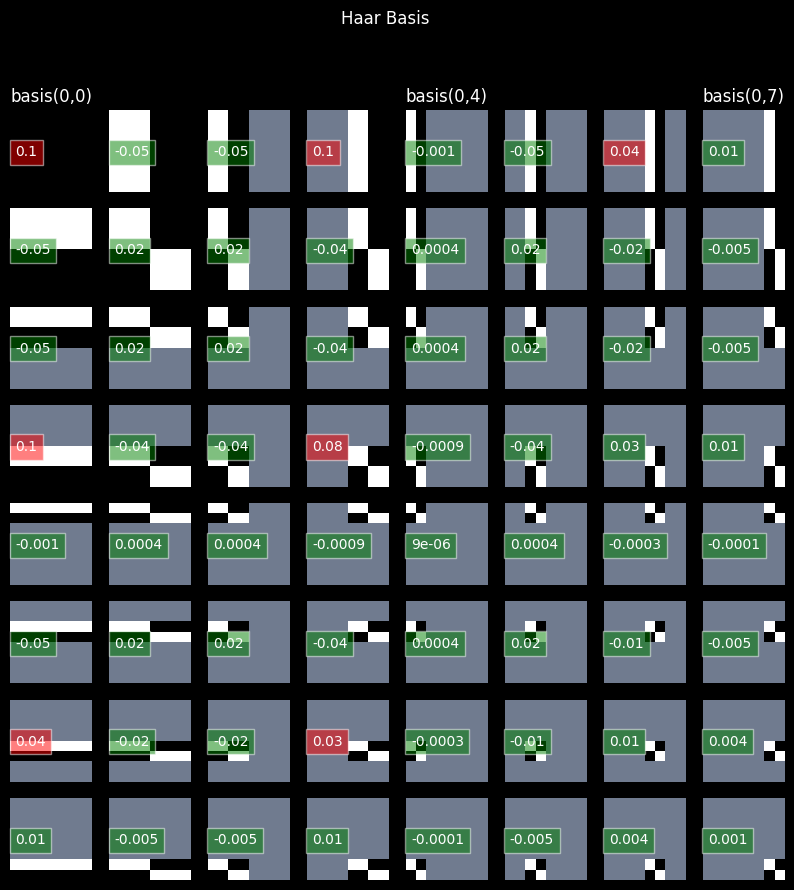

In [653]:
plt.style.use('dark_background')
spatial = True #@param {'type':'boolean'}
fourier = True #@param {'type':'boolean'}
cosine = True #@param {'type':'boolean'}
sine = True #@param {'type':'boolean'}
hadamard = True #@param {'type':'boolean'}
haar = True #@param {'type':'boolean'}
# Spatial Basis
if spatial:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_spatial(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone')
            ax[x,y].set_xticks([])
            ax[x,y].set_yticks([])
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Spatial Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Fourier Basis
if fourier:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_fourier(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone',vmin=-1, vmax=1)
            ax[x,y].axis('off')
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Fourier Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Cosine Basis
if cosine:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_cosine(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone')
            ax[x,y].axis('off')
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Cosine Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
# Cosine Basis
if sine:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_sine(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone')
            ax[x,y].axis('off')
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Sine Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
if hadamard:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_hadamard(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone')
            ax[x,y].axis('off')
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Hadamart Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')
if haar:
    fig, ax = plt.subplots(NFFT, NFFT, figsize=(10, 10))
    COEF = np.zeros((NFFT, NFFT))
    for x in range(NFFT):
        for y in range(NFFT):
            B, C = basis_haar(x, y, NFFT,im=im)
            COEF[x,y]=C[0,0]
            ax[x,y].imshow(B, cmap='bone')
            ax[x,y].axis('off')
    percentile = np.percentile(COEF, 100*perc)
    for x in range(NFFT):
        for y in range(NFFT):
            C = COEF[x,y]
            color = 'green' if C < percentile else 'red'            
            ax[x,y].text(0,NFFT//2,f"{C:.1}",bbox={'facecolor':color,'alpha':0.5})
    fig.suptitle('Haar Basis')
    ax[ 0, 0].set_title('basis(0,0)')
    ax[ 0, 4].set_title('basis(0,4)')
    ax[ 0, 7].set_title('basis(0,7)')